In [1]:
import pandas as pd
import numpy as np
from scipy import sparse as sp

from tqdm.notebook import tqdm

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import DrawingArea, OffsetImage, AnnotationBbox
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

import colorcet as cc
import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import sys
import pathlib


extra_paths = ["../motifcount/", "../vis_util/"]
for p in extra_paths:
    if str(pathlib.Path(p).resolve()) not in sys.path:
        sys.path.append(str(pathlib.Path(p).resolve()))

from modularity import participation_scores, m_table, K_table, kappa_table, z_scores

Loading BokehJS ...

# Load Hemibrain data

In [2]:
oviIN_id = 423101189

In [3]:
HB_version = "1.2"
HB_node_df = pd.read_csv(f"hemibrain/preprocessed-v{HB_version}/preprocessed_nodes.csv", index_col=0)
HB_edge_df = pd.read_csv(f"hemibrain/exported-traced-adjacencies-v{HB_version}/traced-total-connections.csv")
u_edge_df = pd.read_csv(f"hemibrain/preprocessed-v{HB_version}/preprocessed_undirected_edges.csv", index_col=0)

reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params


In [4]:

input_edges = HB_edge_df[HB_edge_df.bodyId_post == oviIN_id]
output_edges = HB_edge_df[HB_edge_df.bodyId_pre == oviIN_id]

In [5]:
oviIN_inputs = input_edges.bodyId_pre.unique()
oviIN_outputs = output_edges.bodyId_post.unique()
inputs = np.setdiff1d(oviIN_inputs, oviIN_outputs)
outputs = np.setdiff1d(oviIN_outputs, oviIN_inputs)
recip = np.intersect1d(oviIN_inputs, oviIN_outputs)
valid_nodes = np.union1d(oviIN_inputs, oviIN_outputs)

In [6]:
HB_node_df["ovi_adj"] = "disconnected"
HB_node_df.loc[inputs, "ovi_adj"] = "input"
HB_node_df.loc[outputs, "ovi_adj"] = "output"
HB_node_df.loc[recip, "ovi_adj"] = "reciprocal"

In [7]:
from colormap import ColorMap

adj = ["input", "reciprocal", "output", "disconnected"]
colors = ["red", "orange", "blue", "lightblue"]

cm = ColorMap(HB_node_df, reneel_params, type_params + ["ovi_adj"])
cm.update_overrides({"ovi_adj": dict(zip(adj, colors))})

In [8]:


HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ["ovi_adj"]],
                              left_on="bodyId_pre", right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ["ovi_adj"]],
                              left_on="bodyId_post", right_index=True, suffixes=["_pre","_post"])

u_edge_df = u_edge_df.merge(HB_node_df[list_of_params + ["ovi_adj"]],
                            left_on="node1", right_index=True)
u_edge_df = u_edge_df.merge(HB_node_df[list_of_params + ["ovi_adj"]],
                            left_on="node2", right_index=True, suffixes=["_1", "_2"])

# Correlation Coefficients of Inputs

Trying to compute the correlation coefficients of the input of each neuron

In [3]:
# the files in hemibrain/exported-traced-adjacencies-* come from executing the code below
# from neuprint import fetch_traced_adjacencies
# traced_df, roi_conn_df = fetch_traced_adjacencies('hemibrain/exported-traced-adjacencies-v1.2.1')
HB_edge_df = pd.read_csv("hemibrain/exported-traced-adjacencies-v1.2.1/total-connections.csv")  
HB_node_df = pd.read_csv("hemibrain/exported-traced-adjacencies-v1.2.1/neurons.csv", index_col=0).fillna("None")
# the file ../flyibrain-clustering/oviIN/preprocessed come from Rhessa's repo; the file I'm loading is this one:
# https://github.com/RhessaWL/flybrain-clustering/blob/main/oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv
oviIN_nodes = pd.read_csv("../flybrain-clustering/oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv", index_col=0)
valid_ovi_nodes = np.intersect1d(oviIN_nodes.index, HB_node_df.index)

In [4]:
shuffled_df = oviIN_nodes.loc[valid_ovi_nodes, ["0.0", "0.05", "0.1", "0.5", "0.75", "1.0", "instance", "celltype"]]
chis = ["0.0"]
n_trials = 100

for chi in chis:
    shuffles = np.zeros((len(shuffled_df), n_trials), dtype=int)
    for t in range(n_trials):
        shuffles[:, t] = shuffled_df[chi].values[np.random.permutation(len(shuffled_df))]
        # shuffles[:, t] = np.random.shuffle(shuffled_df[chi].values)
    tmp = pd.DataFrame(shuffles, index=shuffled_df.index, columns=[f"{chi}_s{t}" for t in range(n_trials)])
    # for t in range(n_trials):
    #     shuffled_df[f"{chi}_shuffle{t}"] = np.random.shuffle(shuffled_df[chi].values)
    shuffled_df = shuffled_df.merge(tmp, left_index=True, right_index=True)
# shuffled_df = shuffled_df.copy()
shuffled_df

,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,0.0_s0,0.0_s1,...,0.0_s90,0.0_s91,0.0_s92,0.0_s93,0.0_s94,0.0_s95,0.0_s96,0.0_s97,0.0_s98,0.0_s99
id,,,,,,,,,,,,,,,,,,,,,
263674097,5,8,8,154,202,198,LHPD2a5_a_R,LHPD2a5_a,2,2,...,2,2,3,3,2,3,5,2,5,2
266187480,5,5,20,240,300,251,SMP349_R,SMP349,2,3,...,4,3,2,5,3,5,5,5,1,4
266187559,5,5,20,90,110,252,SLP399_R,SLP399,1,5,...,5,1,3,1,2,1,2,3,3,5
267214250,5,5,20,241,301,253,pC1b_R,pC1b,5,1,...,2,5,4,2,3,3,1,1,2,2
267223104,5,5,20,242,302,254,SMP025_R,SMP025,2,5,...,2,5,3,2,3,2,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901225755,2,7,7,357,141,153,None,None,5,3,...,1,1,1,1,5,3,3,1,2,2
5901227238,2,7,7,130,229,145,None,None,5,5,...,1,1,2,5,2,4,1,5,2,1
5901232053,1,13,15,248,311,266,SMP272(PDL21)_L,SMP272,1,5,...,3,4,5,2,5,2,1,2,3,2


In [5]:
valid_ovi_nodes

array([ 263674097,  266187480,  266187559, ..., 5901232053, 6400000773,
       7112622044])

In [6]:
valid_ovi_nodes = np.array(sorted(valid_ovi_nodes, key=lambda x: oviIN_nodes.loc[x, "0.0"]))
valid_ovi_nodes

array([ 296199021,  296203325,  296203440, ..., 5901203505, 5901221890,
       6400000773])

In [7]:
test_ovi_nodes = valid_ovi_nodes[:5]
test_ovi_nodes

array([296199021, 296203325, 296203440, 296531366, 296535655])

In [8]:
# This takes ~15 seconds on my work laptop and eats up several gigabytes of memory. You have been warned!
HB_matrix = HB_edge_df.pivot_table(values="weight", index="bodyId_post", columns="bodyId_pre", fill_value=0.0)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


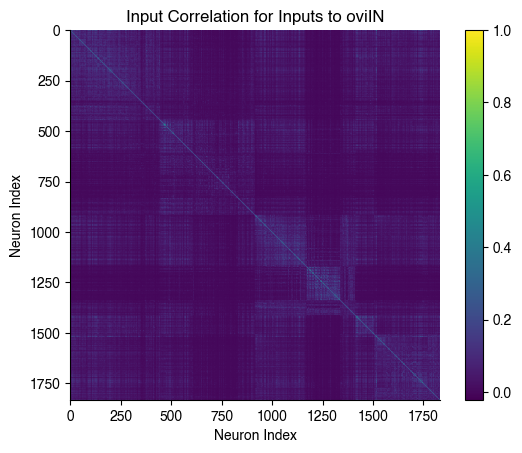

In [18]:
X = HB_matrix.loc[valid_ovi_nodes].values
C = np.corrcoef(X)
plt.imshow(C)
plt.title("Input Correlation for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
# plt.xticks(range(len(valid_ovi_nodes)), valid_ovi_nodes, rotation="vertical")
plt.savefig(f"figures/input_correlation/all_input_correlation.pdf", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


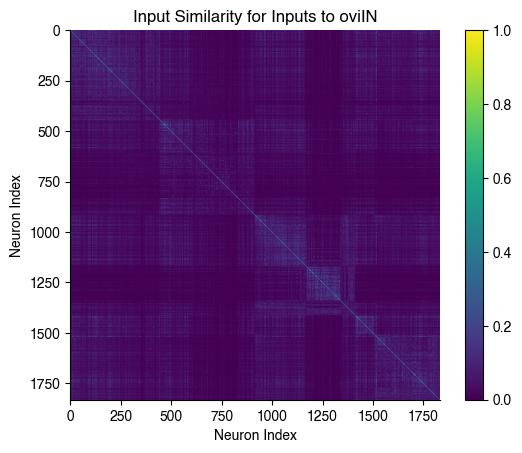

In [19]:
Xunit = X / np.sqrt(np.sum(X ** 2, axis=1))[:,None]
S = Xunit @ Xunit.T
plt.imshow(S)
plt.title("Input Similarity for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
plt.savefig(f"figures/input_correlation/all_input_similarity.pdf", bbox_inches="tight")

In [14]:
corr_df = pd.DataFrame([[valid_ovi_nodes[i], valid_ovi_nodes[j], C[i,j], S[i,j]] for (i,j) in combinations_with_replacement(range(len(valid_ovi_nodes)), 2)],
                       columns=["bodyId1", "bodyId2", "correlation", "similarity"])

# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId1", right_index=True)
# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId2", right_index=True, suffixes=["_1","_2"])
corr_df = corr_df.merge(shuffled_df, left_on="bodyId1", right_index=True)
corr_df = corr_df.merge(shuffled_df, left_on="bodyId2", right_index=True, suffixes=["_1", "_2"])
corr_df

,bodyId1,bodyId2,correlation,similarity,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,1.0_1,...,0.0_s90_2,0.0_s91_2,0.0_s92_2,0.0_s93_2,0.0_s94_2,0.0_s95_2,0.0_s96_2,0.0_s97_2,0.0_s98_2,0.0_s99_2
0,296199021,296199021,1.000000,1.000000,1,5,6,244,304,256,...,5,4,5,2,3,2,5,1,1,2
1,296199021,296203325,0.368179,0.370403,1,5,6,244,304,256,...,5,5,1,5,3,2,4,3,2,3
1832,296203325,296203325,1.000000,1.000000,1,5,6,90,305,258,...,5,5,1,5,3,2,4,3,2,3
2,296199021,296203440,0.124859,0.127660,1,5,6,244,304,256,...,3,3,3,1,2,4,2,1,3,3
1833,296203325,296203440,0.316126,0.318836,1,5,6,90,305,258,...,3,3,3,1,2,4,2,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679017,5901201909,6400000773,0.023559,0.027683,5,5,20,306,502,410,...,1,2,5,2,3,5,4,2,5,1
1679021,5901203310,6400000773,0.105317,0.107882,5,5,6,328,446,434,...,1,2,5,2,3,5,4,2,5,1
1679024,5901203505,6400000773,0.016982,0.020159,5,5,20,271,425,392,...,1,2,5,2,3,5,4,2,5,1
1679026,5901221890,6400000773,0.043026,0.046729,5,5,20,240,318,273,...,1,2,5,2,3,5,4,2,5,1


In [15]:
valid_corrs = corr_df[corr_df.bodyId1 != corr_df.bodyId2]

In [16]:
def corrDF_to_matrix(df, col1, col2, measure, stat):
    group_corrs = df.groupby([col1, col2]).agg({measure: stat})
    ngroups = df[col1].max()
    C = np.zeros((ngroups, ngroups))
    for i in range(ngroups):
        for j in range(i, ngroups):
            C[i,j] = C[j,i] = group_corrs.loc[(i+1, j+1), measure]
    return C

In [17]:
# true_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs

correlation                     similarity                    
                 median      mean       std     median      mean       std
0.0_1 0.0_2                                                               
1     1        0.033626  0.064780  0.087271   0.036892  0.067869  0.087016
      2        0.003185  0.018195  0.042458   0.006307  0.021262  0.042489
      3        0.002726  0.021010  0.050872   0.006383  0.024704  0.050652
      4        0.016768  0.043070  0.069552   0.019452  0.045542  0.069306
      5        0.012525  0.036012  0.061598   0.015880  0.039203  0.061386
2     2        0.009964  0.037216  0.073250   0.012923  0.040043  0.073227
      3        0.000494  0.016447  0.043936   0.003913  0.019943  0.043925
      4        0.003433  0.022721  0.048536   0.005889  0.025096  0.048621
      5        0.000110  0.013877  0.039437   0.003157  0.016960  0.039424
3     3        0.017849  0.054311  0.090538   0.021913  0.058348  0.090253
      4        0.004902  0.024422  0.053518   0.007768  0.027288  0.053339
      5        0.004417  0.022842  0.050119   0.008023  0.026521  0.049962
4     4        0.050269  0.094297  0.126466   0.052143  0.096104  0.126216
      5        0.012814  0.037315  0.066659   0.015557  0.039806  0.066356
5     5        0.035533  0.067516  0.092716   0.038884  0.070587  0.092403

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


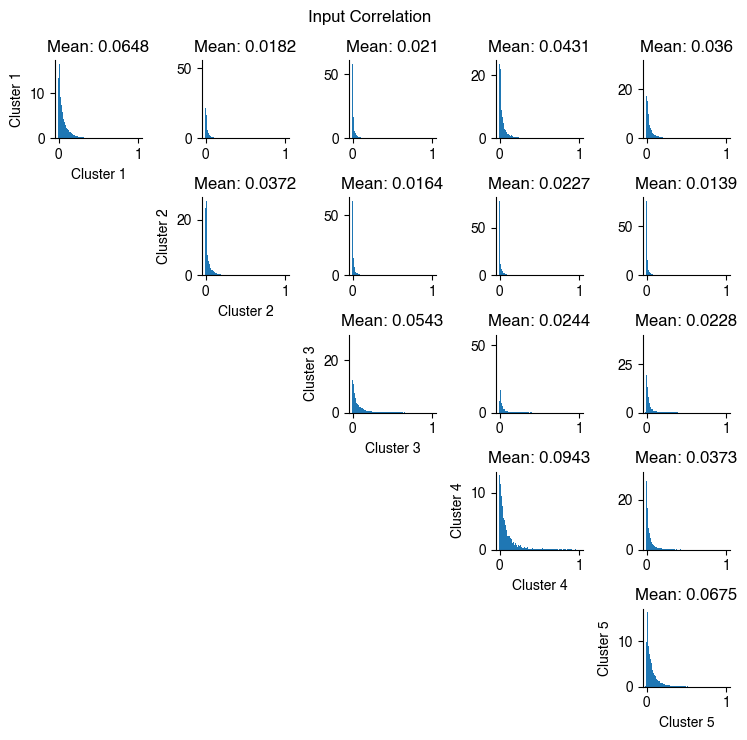

In [21]:
eps = 0.05
measure = "correlation"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(5):
    for j in range(i,5):
        plt.subplot(5,5,i*5 + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

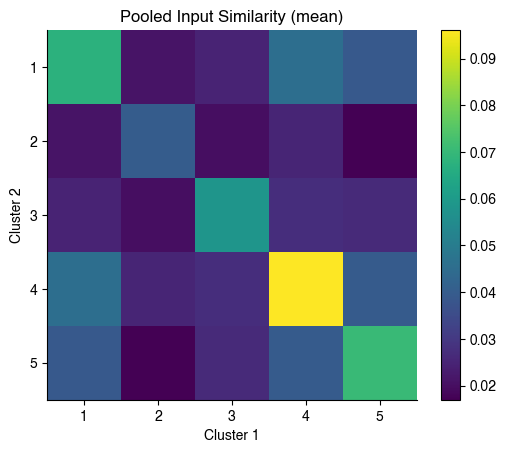

In [23]:
measure = "similarity"
stat = "mean"
# cluster_corrs = corr_df.groupby(["0.0_1", "0.0_2"]).agg({measure: stat})
# cluster_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": "mean"})
CC = np.zeros((5,5))
# for i in range(5):
#     for j in range(i, 5):
#         CC[i,j] = cluster_corrs.loc[(i+1,j+1), (measure, stat)]
#         CC[j,i] = cluster_corrs.loc[(i+1,j+1), (measure, stat)]
CC = corrDF_to_matrix(valid_corrs, "0.0_1", "0.0_2", measure, stat)

plt.imshow(CC)
plt.title(f"Pooled Input {measure.capitalize()} ({stat})")
plt.xticks(range(5), range(1,6))
plt.yticks(range(5), range(1,6))
plt.xlabel("Cluster 1")
plt.ylabel("Cluster 2")
plt.colorbar()

In [20]:
n_trials = 100
lots_of_C = np.zeros((n_trials, 5, 5))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


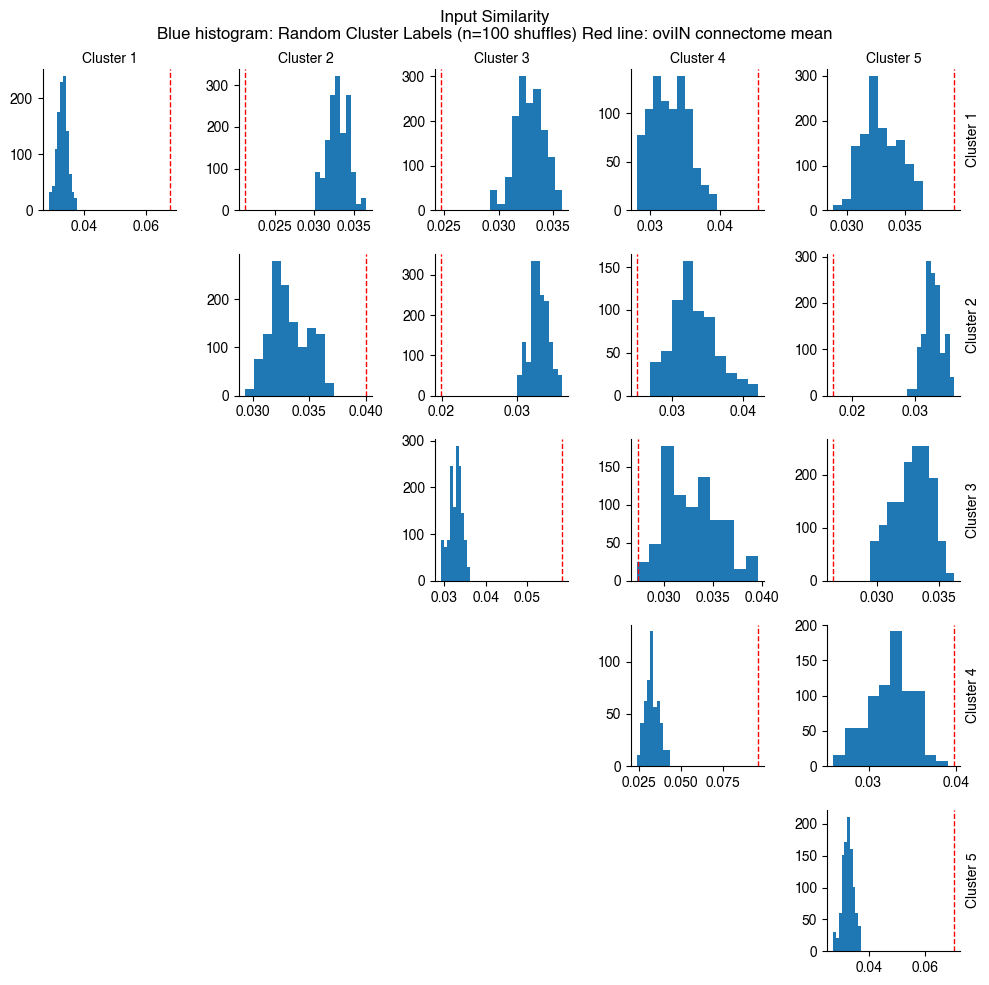

In [19]:
eps = 0.05
measure = "similarity"
stat = "mean"

lots_of_C = np.zeros((n_trials, 5, 5))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

plt.figure(tight_layout="tight",
           figsize=(10,10))
plt.suptitle(f"Input {measure.capitalize()}\nBlue histogram: Random Cluster Labels (n={n_trials} shuffles)\tRed line: oviIN connectome {stat}")
for i in range(5):
    for j in range(i,5):
        plt.subplot(5,5,i*5 + j + 1)
        # plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
        #          bins=100, density=True)
        plt.axvline(CC[i, j], color="red", linewidth=1, linestyle="dashed")
        plt.hist(lots_of_C[:, i, j], bins=10, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        # plt.xlim(-eps, 1 + eps)
        # plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        # if j == i:
        #     plt.xlabel(f"Cluster {i+1}")
        #     plt.ylabel(f"Cluster {j+1}")
        if i == 0:
            plt.gca().xaxis.set_label_position("top")
            plt.xlabel(f"Cluster {j+1}")
            # plt.title(f"Cluster {j+1}")
        if j == 4:
            plt.gca().yaxis.set_label_position("right")
            plt.ylabel(f"Cluster {i+1}")

plt.savefig(f"figures/input_correlation/comparison_to_shuffle_{measure}.pdf")

Text(0, 0.5, 'Frequency')

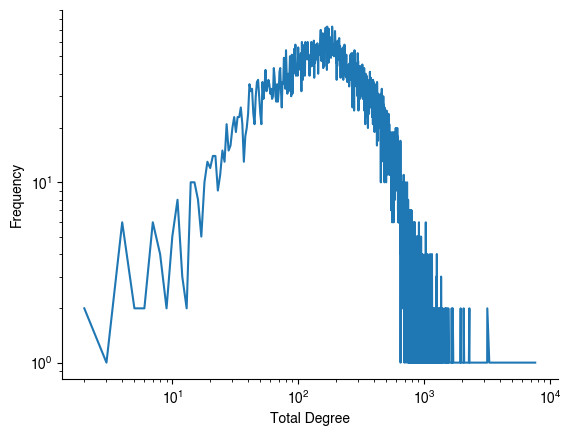

In [22]:
outdegree = HB_edge_df.groupby("bodyId_pre").agg({"bodyId_post":"count"}).rename(columns={"bodyId_post":"neighbors"})
indegree = HB_edge_df.groupby("bodyId_post").agg({"bodyId_pre":"count"}).rename(columns={"bodyId_pre":"neighbors"})
degree_sequence = outdegree.add(indegree, fill_value=0)
ds = degree_sequence.neighbors.value_counts().sort_index()
plt.plot(ds.index, ds.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total Degree")
plt.ylabel("Frequency")

In [ ]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy

hemibrain_version = "v1.2.1"
auth_token_file = open("flybrain.auth", 'r')
auth_token = next(auth_token_file).strip()
np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
print("neuprint Client set up as `np_Client`, version", np_client.fetch_version())

neuprint Client set up as `np_Client`, version 0.1.0


In [ ]:
from neuprint import fetch_traced_adjacencies

traced_df, roi_conn_df = fetch_traced_adjacencies('hemibrain121')

  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
display(traced_df)
display(roi_conn_df.head())

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21733,7112579856,LC20,LC20
21734,7112615127,AVLP335,AVLP335_R
21735,7112617294,AVLP331,AVLP331_R
21736,7112622044,LAL137,LAL137(PVL05)_L


,bodyId_pre,bodyId_post,roi,weight
0,200326126,264083994,SLP(R),3
1,200326126,295816140,ICL(R),2
2,200326126,295816140,SCL(R),2
3,200326126,295816140,PLP(R),1
4,200326126,296203440,SCL(R),1


# Prominence

In [30]:
HB_matrix.shape

(21737, 21691)

In [34]:
HB_matrix.sum(axis=0)

bodyId_pre
200326126     1149
202916528       89
203253072      125
203253253      912
203257652       52
              ... 
7112579856     432
7112615127     429
7112617294     397
7112622044    3697
7112622236       8
Length: 21691, dtype: int64

In [23]:
normalized_inputs = HB_matrix * (1 / HB_matrix.sum(axis=1))
normalized_outputs = HB_matrix / HB_matrix.sum(axis=0)

In [24]:
normalized_outputs

bodyId_pre,200326126,202916528,203253072,203253253,203257652,203594169,203594175,203598499,203598504,203598542,...,5901231246,5901231325,5901232053,6400000773,7112579848,7112579856,7112615127,7112617294,7112622044,7112622236
bodyId_post,,,,,,,,,,,,,,,,,,,,,
200326126,0.0,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
202916528,0.0,0.000000,0.000,0.0,0.019231,0.000000,0.000000,0.001830,0.000000,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
203253072,0.0,0.000000,0.000,0.0,0.000000,0.000000,0.021978,0.002745,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
203253253,0.0,0.022472,0.136,0.0,0.019231,0.109756,0.098901,0.000000,0.026316,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000541,0.0
203257652,0.0,0.011236,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112579856,0.0,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
7112615127,0.0,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
7112617294,0.0,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002331,0.0,0.000000,0.0


In [89]:
len(oviIN_nodes[oviIN_nodes.celltype.str.contains("SMP")]) / len(oviIN_nodes)

0.27956989247311825

In [87]:
len(tmp)

1832

In [76]:
HB_node_df[HB_node_df["type"].str.contains("OA")]

,type,instance
bodyId,,
329566174,OA-VPM3,OA-VPM3(NO2/NO3)_R
576825965,OA-VUMa7,OA-VUMa7_R
638481581,OA-VUMa2,OA-VUMa2_R
730709173,OA-ASM1,OA-ASM1_R
736860990,OA-VUMa6,OA-VUMa6_R
738155917,OA-ASM1,OA-ASM1_R
767473384,OA-VPM4,OA-VPM4
821344462,OA-ASM2,OA-ASM2_R
884916323,OA-ASM3,OA-ASM3(ADM10)_L


In [47]:
randomIds = np.random.choice(HB_node_df.index, 5)

In [28]:
np.argsort(HB_matrix.loc[oviIN_id], order="descending")

bodyId_pre
200326126         0
202916528     14265
203253072     14264
203253253     14263
203257652     14262
              ...  
7112579856     1899
7112615127    19526
7112617294    14579
7112622044    21213
7112622236     3950
Name: 423101189, Length: 21691, dtype: int64

In [31]:
input_weights = HB_matrix.loc[oviIN_id, valid_ovi_nodes]
np.argsort(input_weights, order="descending")

bodyId_pre
296199021      915
296203325     1120
296203440      455
296531366     1117
296535655      458
              ... 
5901201909     445
5901203310     854
5901203505     794
5901221890     902
6400000773     169
Name: 423101189, Length: 1832, dtype: int64

In [33]:
tmp = HB_matrix[valid_ovi_nodes].rank(method="first")
tmp.loc[oviIN_id, valid_ovi_nodes]

bodyId_pre
296199021     21715.5
296203325     21737.0
296203440     21674.0
296531366     21735.0
296535655     21651.0
               ...   
5901201909    21595.5
5901203310    21713.0
5901203505    21503.5
5901221890    21587.5
6400000773    21671.0
Name: 423101189, Length: 1832, dtype: float64

Text(0, 0.5, "oviIN's rank as output")

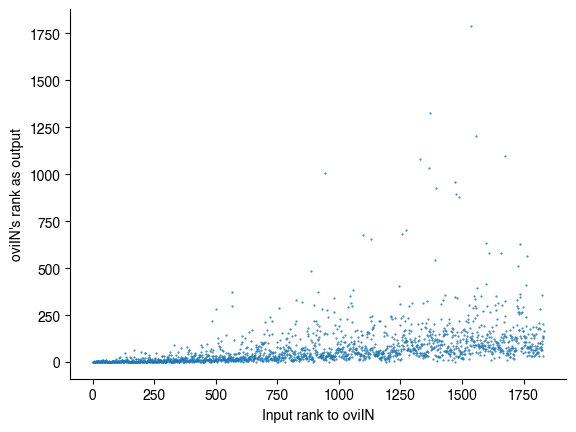

In [37]:
tmp = HB_matrix[valid_ovi_nodes].rank(method="first", ascending=False)
input_weights = HB_matrix.loc[oviIN_id, valid_ovi_nodes].rank(method="first", ascending=False)
plt.scatter(input_weights, tmp.loc[oviIN_id, valid_ovi_nodes],
            marker=".",s=1)
plt.xlabel("Input rank to oviIN")
plt.ylabel("oviIN's rank as output")

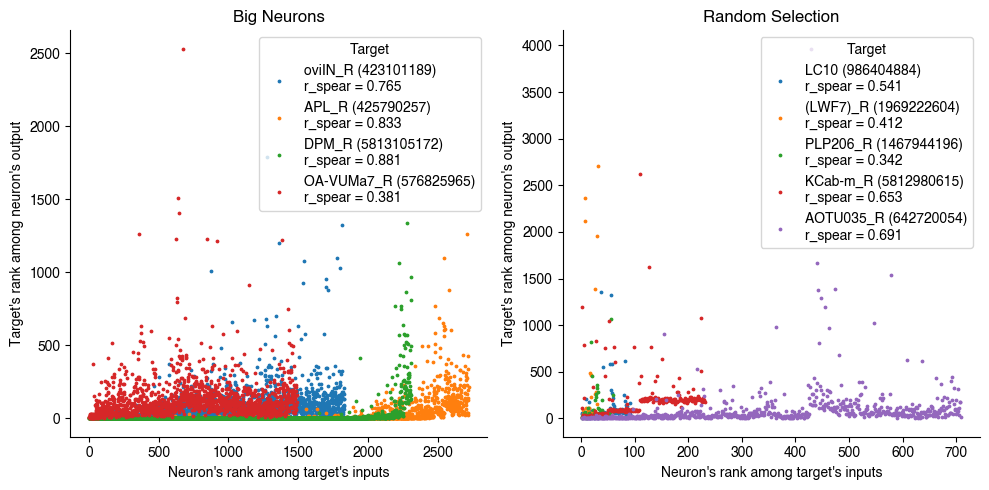

In [49]:
from scipy.stats import spearmanr

def rankcorrplot(bodyIds, matrix, normed_outputs, title="Missing Title"):
    for bodyId in bodyIds:
        criteria = (matrix.loc[bodyId, :] != 0)
        cols = matrix.columns[criteria]
        norm_input = matrix.loc[bodyId, criteria]
        norm_input = norm_input / norm_input.sum()
        norm_output = normed_outputs.loc[bodyId, criteria]
        ranked_input = matrix.loc[bodyId, criteria].rank(method="first", ascending=False)
        ranked_output = matrix[cols].rank(method="first", ascending=False)
        r = spearmanr(norm_input, norm_output).correlation
        # plt.figure()
        plt.scatter(ranked_input, ranked_output.loc[bodyId, :],
                    s=3, label=f"{HB_node_df.loc[bodyId, 'instance']} ({bodyId})\nr_spear = {round(r, 3)}")
        # plt.scatter(norm_input, norm_output,
        #             # marker=".",
        #             s=3, label=f"{HB_node_df.loc[bodyId, 'instance']} ({bodyId})\nr_spear = {round(r, 3)}")
        plt.xlabel("Neuron's rank among target's inputs")
        plt.ylabel("Target's rank among neuron's output")
        # plt.title(f"Inputs to {HB_node_df.loc[bodyId, 'instance']} ({bodyId})")
        plt.title(title)
    plt.legend(title="Target")


bodyIds = [oviIN_id, 425790257, 5813105172, 576825965]
plt.figure(tight_layout="tight",
           figsize=(10,5))
plt.subplot(1,2,1)
rankcorrplot(bodyIds, HB_matrix, normalized_outputs, title="Big Neurons")

plt.subplot(1,2,2)
rankcorrplot(randomIds, HB_matrix, normalized_outputs, title="Random Selection")
# for bodyId in randomIds:
#     criteria = (HB_matrix.loc[bodyId, :] != 0)
#     norm_input = HB_matrix.loc[bodyId, criteria]
#     norm_input = norm_input / norm_input.sum()
#     # plt.figure()
#     plt.scatter(norm_input, normalized_outputs.loc[bodyId,criteria],
#                 marker=".",
#                 s=3, label=HB_node_df.loc[bodyId, 'instance'])
#     plt.xlabel("Fraction of Input to Target")
#     plt.ylabel("Fraction of output of presyn")
#     plt.title("Random Selection")
# plt.legend(title="Targets")

In [ ]:
# let's redo this using average rank
# also, what if connections were distributed uniformly? this amounts to shuffling the edges of the network (with their weights)

In [96]:
HB_edge_df.merge(HB_edge_df.groupby("bodyId_pre").agg({"weight":"sum"}), left_on="bodyId_pre", right_index=True, suffixes=["", "_pre"])

,bodyId_pre,bodyId_post,weight,weight_pre
0,203253253,295473947,1,912
1,203253253,5813040123,1,912
2,203253253,5813130028,1,912
3,203253253,5813008848,1,912
4,203253253,328943204,1,912
...,...,...,...,...
3550056,5901226003,1535488185,3,322
3550057,5901226003,915105429,25,322
3550058,5901226003,5813063587,12,322
3550059,5901226003,1225540409,2,322


In [100]:
output_rank = HB_matrix.rank(axis=0, ascending=False)

In [117]:
output_prominence = (output_rank * HB_matrix).sum(axis=1) / HB_matrix.sum(axis=1)
output_prominence.name = "rank"

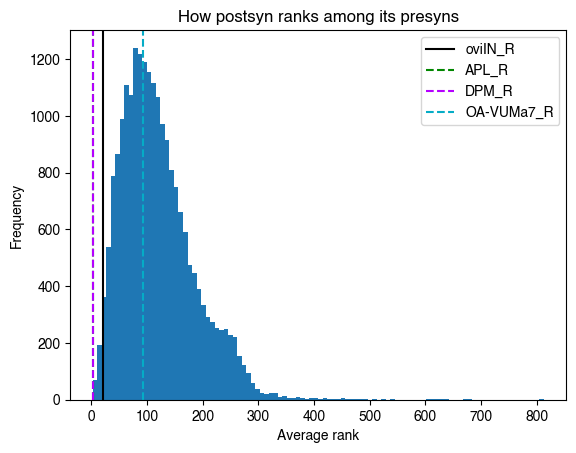

In [132]:
import colorcet as cc
bodyIds = [oviIN_id, 425790257, 5813105172, 576825965]
# randomIds = np.random.choice(HB_node_df.index, 5)

plt.hist(output_prominence, bins=100)
for bId, c in zip(bodyIds, cc.glasbey_light):
    instance = HB_node_df.loc[bId, "instance"]
    vlinekw = dict(color=c, label=instance)
    if instance.startswith("ovi"):
        vlinekw["color"] = "black"
    else:
        vlinekw["linestyle"] = "dashed"
    if bId in randomIds:
        vlinekw["linestyle"] = "dotted"
        vlinekw["linewidth"] = 1
    plt.axvline(output_prominence[bId], **vlinekw)
plt.title("How postsyn ranks among its presyns")
plt.xlabel("Average rank")
plt.ylabel("Frequency")
plt.legend()
# plt.xscale("log")

In [151]:
tmp = HB_edge_df.groupby("bodyId_post").agg({"weight":"sum"}).merge(output_prominence, left_index=True, right_index=True)
tmp

,weight,rank
bodyId_post,,
200326126,862,103.263921
202916528,373,127.091153
203253072,319,127.481191
203253253,1740,37.771839
203257652,230,134.506522
...,...,...
7112579856,255,84.376471
7112615127,491,128.718941
7112617294,566,112.728799


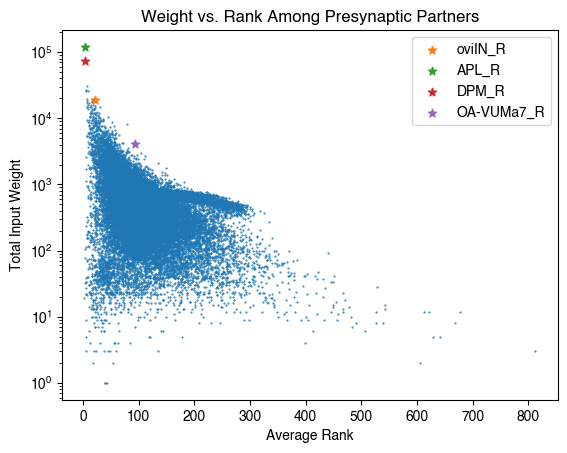

In [168]:
# plt.hist2d(tmp["rank"], tmp["weight"], bins=1000, cmin=1)
# plt.yscale("log")
plt.scatter(tmp["rank"], tmp["weight"], s=1, marker=".")
for bId in bodyIds:
    plt.scatter([tmp.loc[bId, "rank"]], [tmp.loc[bId, "weight"]], marker="*",
                label=HB_node_df.loc[bId, "instance"])
plt.yscale("log")
plt.title("Weight vs. Rank Among Presynaptic Partners")
plt.xlabel("Average Rank")
plt.ylabel("Total Input Weight")
plt.legend()

## Shuffled prominence
We're going to take each input neuron to oviIN and shuffle its output weights. THat is, we preserve who it's connected to, but shuffle the weights of each of those edges. Then, we'll compute oviIN's rank among that neuron's outputs. We then compute oviIN's (unweighted) average rank among its (now-shuffled) inputs. I think?

The more I think about this, the more I wonder what it will actually tell us. Since the end computation is really just looking at rank, shuffling the weights is no different than just choosing a number for oviIN's rank, chosen from between 1 and N_outputs. Is that really all that interesting?

In [50]:
bodyId = np.random.choice(valid_ovi_nodes)

In [58]:
# HB_matrix[bodyId].rank(method="first", ascending=False)[oviIN_id]
HB_matrix[HB_matrix[bodyId] != 0][bodyId].rank(ascending=False, method="min")[oviIN_id]

51.0

([<matplotlib.axis.XTick at 0x3ab941220>,
 [Text(0, 0, '547552266'),
  Text(1, 0, '5813057162'),
  Text(2, 0, '518930199'),
  Text(3, 0, '5813020993'),
  Text(4, 0, '361722354'),
  Text(5, 0, '643398197'),
  Text(6, 0, '298258513'),
  Text(7, 0, '544706811'),
  Text(8, 0, '5813056423'),
  Text(9, 0, '579963818'),
  Text(10, 0, '608278754'),
  Text(11, 0, '358847551'),
  Text(12, 0, '609975449'),
  Text(13, 0, '669666822'),
  Text(14, 0, '488231898'),
  Text(15, 0, '451390676'),
  Text(16, 0, '543412036'),
  Text(17, 0, '576566223'),
  Text(18, 0, '5813057933'),
  Text(19, 0, '642715875'),
  Text(20, 0, '541723731'),
  Text(21, 0, '674427795'),
  Text(22, 0, '673072855'),
  Text(23, 0, '514837265'),
  Text(24, 0, '639655378'),
  Text(25, 0, '455154890'),
  Text(26, 0, '452742028'),
  Text(27, 0, '705463175'),
  Text(28, 0, '638985608'),
  Text(29, 0, '328935472'),
  Text(30, 0, '296850634'),
  Text(31, 0, '5813075875'),
  Text(32, 0, '298258399'),
  Text(33, 0, '5813096198'),
  Text(34,

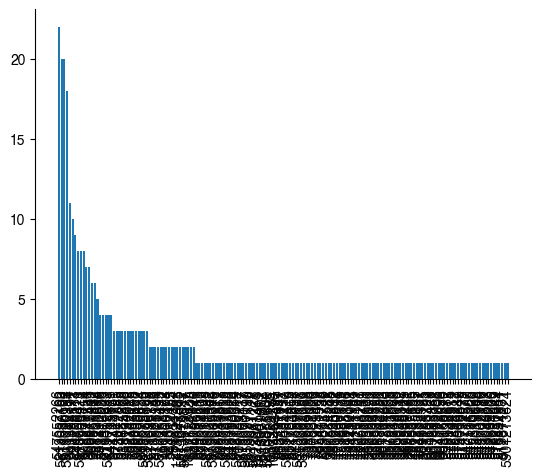

In [73]:
v = HB_matrix[HB_matrix[bodyId] != 0][bodyId].sort_values(ascending=False)
plt.bar(range(len(v)), v)
plt.xticks(range(len(v)), v.index, rotation=90)

# Participation Coefficients

In [16]:
oviIN_nodes = pd.read_csv("../flybrain-clustering/oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv", index_col=0)
key_to_id = dict(zip(oviIN_nodes["key"], oviIN_nodes.index))
# oviIN_nodes = oviIN_nodes.rename(columns={"key": "shifted_id"})
display(oviIN_nodes.head())

oviIN_params = [c for c in list_of_params if c in oviIN_nodes.columns]

oviIN_edges = pd.read_csv("../flybrain-clustering/oviIN/preprocessed_inputs-v1.2.1/preprocessed_undirected_edges.csv", index_col=0)
for i in [1,2]:
    oviIN_edges[f"node{i}"] = oviIN_edges[f"node{i}"].apply(lambda x: key_to_id[x])
oviIN_edges = oviIN_edges.merge(oviIN_nodes[oviIN_params], left_on="node1", right_index=True)
oviIN_edges = oviIN_edges.merge(oviIN_nodes[oviIN_params], left_on="node2", right_index=True, suffixes=["_1", "_2"])
display(oviIN_edges.head())

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,1,CL229_R,CL229,100,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1005952640,2,2,1,1,2,2,2,IB058_R,IB058,664,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
1006928515,3,1,1,1,3,3,3,CL300_R,CL300,86,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1007260806,4,2,1,1,4,4,4,CL301_R,CL301,119,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,499,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


,node1,node2,total_weight,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,1.0_1,celltype_1,instance_1,0.0_2,0.05_2,0.1_2,0.5_2,0.75_2,1.0_2,celltype_2,instance_2
0,1003215282,1039685005,1,1,1,1,1,1,1,CL229,CL229_R,1,1,1,1,1,42,CL243,CL243_R
1,1003215282,1134140939,1,1,1,1,1,1,1,CL229,CL229_R,3,3,4,74,91,97,CL167,CL167_R
2004,1013416147,1134140939,6,2,3,4,18,18,18,CRE100,CRE100_R,3,3,4,74,91,97,CL167,CL167_R
14546,1099389583,1134140939,1,1,13,6,62,75,85,IB053,IB053_R,3,3,4,74,91,97,CL167,CL167_R
16828,1130783454,1134140939,2,2,1,1,73,89,94,PS202,PS202_R,3,3,4,74,91,97,CL167,CL167_R


In [98]:
# I_edges = u_edge_df[u_edge_df.node1.isin(oviIN_inputs) & u_edge_df.node2.isin(oviIN_inputs)]
I_edges = oviIN_edges[oviIN_edges.total_weight >= oviIN_edges]
K_tbl = K_table(I_edges)
participation_df = pd.DataFrame(index=oviIN_inputs)
participation_df.index.name = "bodyId"
for chi in reneel_params:
    if chi not in oviIN_params:
        continue
    m_tbl = m_table(I_edges, chi)
    scores = participation_scores(I_edges, chi, m_tbl=m_tbl, K_tbl=K_tbl)
    scores.index.name = "bodyId"
    scores.name = chi
    participation_df = participation_df.merge(scores, left_index=True, right_index=True)
participation_df = participation_df.merge(HB_node_df[["celltype", "instance"]], left_index=True, right_index=True, how="left")

In [99]:
participation_df

,0.0,0.05,0.1,0.5,0.75,1.0,celltype,instance
bodyId,,,,,,,,
266187480,0.468863,0.571378,0.554668,0.753310,0.762923,0.763052,SMP349,SMP349_R
263674097,0.677269,0.666513,0.667137,0.941191,0.949237,0.958087,LHPD2a5_a,LHPD2a5_a_R
267564140,0.205078,0.278863,0.264323,0.794705,0.826172,0.840061,SLP428,SLP428_R
266187559,0.278605,0.281072,0.360894,0.881658,0.927966,0.944656,SLP399,SLP399_R
267214250,0.381705,0.486743,0.492189,0.887101,0.959558,0.962236,pC1b,pC1b_R
...,...,...,...,...,...,...,...,...
5901212906,0.529904,0.686991,0.729858,0.952777,0.961365,0.968697,None,SLPXXX(SCBXXX)_R
5901225755,0.594047,0.747435,0.734787,0.893032,0.896187,0.896845,None,None
5901203505,0.526080,0.529025,0.546302,0.756360,0.846817,0.859477,SLP212,SLP212_R


In [100]:
participation_df.celltype.value_counts()

None      196
FS1A       44
FS3        28
FC2C       19
FS1B       19
         ... 
SMP423      1
SMP554      1
CRE088      1
SMP045      1
CRE011      1
Name: celltype, Length: 965, dtype: int64

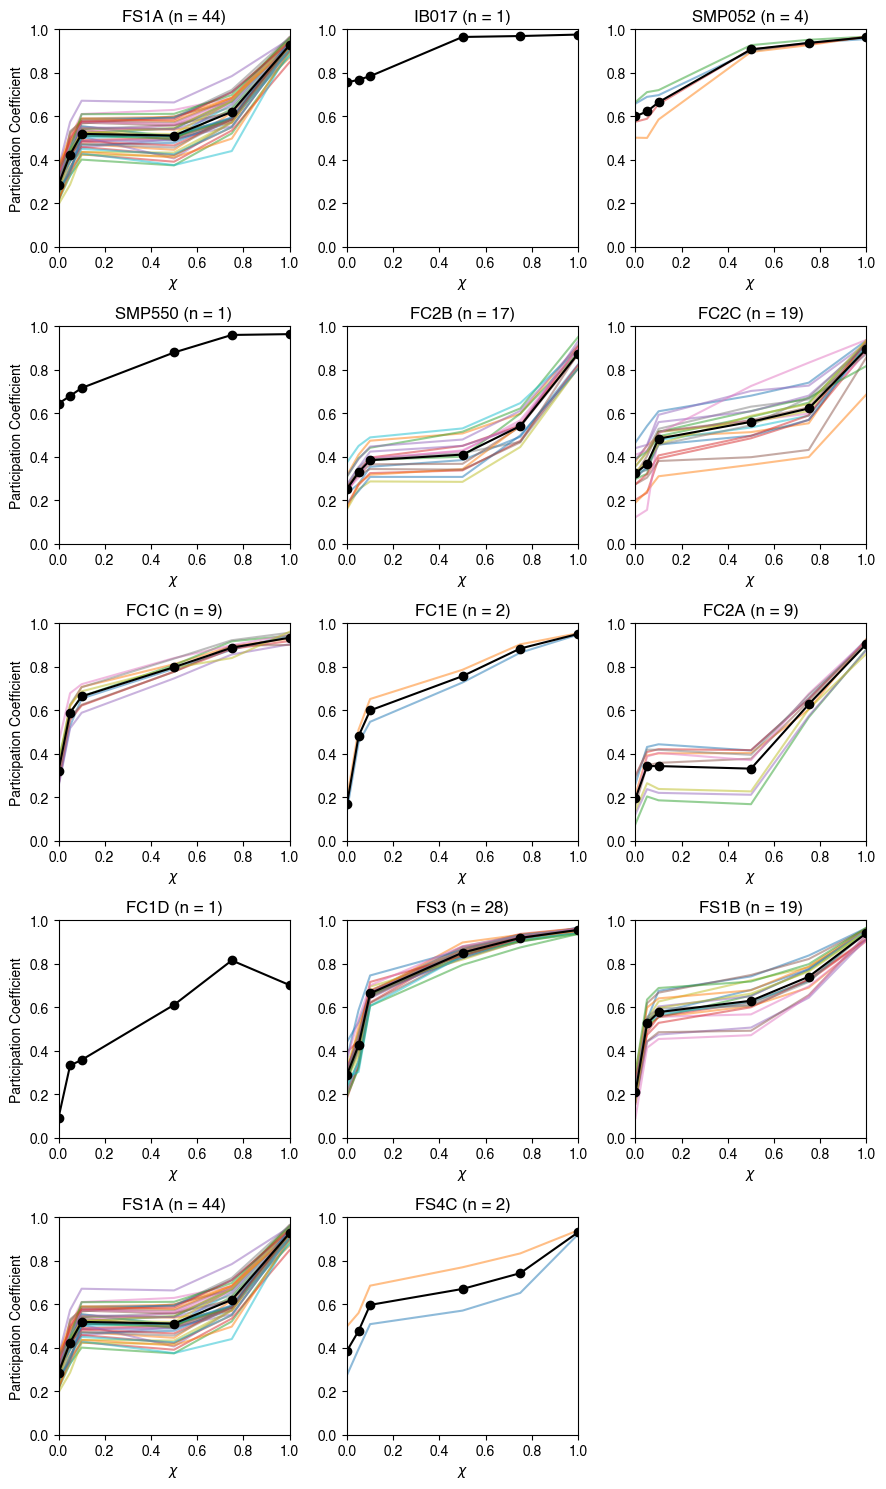

In [112]:
types_of_interest = ["FS1A", "IB017", "SMP052", "SMP550"] + \
    participation_df[participation_df.celltype.str.contains("FC")].celltype.unique().tolist() + \
    participation_df[participation_df.celltype.str.contains("FS")].celltype.unique().tolist()
    # participation_df[participation_df.celltype.str.contains("SMP")].celltype.unique().tolist()
n_plots = len(types_of_interest)
n_cols = 3
n_rows = np.ceil(n_plots / n_cols).astype(int)
plt.figure(figsize=(3 * n_cols, 3 * n_rows), tight_layout="tight")
# chi_values = list(map(float, reneel_params))
chi_values = [float(x) for x in reneel_params if x in oviIN_params]
chi_columns = list(map(str, chi_values))
for i, t in enumerate(types_of_interest, start=1):
    plt.subplot(n_rows, n_cols, i)
    selected_cells = participation_df[participation_df.celltype == t]
    values = selected_cells[chi_columns]
    if len(selected_cells) > 1:
        plt.plot(chi_values, values.values.T, alpha=0.5)
    plt.plot(chi_values, values.values.mean(axis=0), color="black", marker="o")
    plt.title(f"{t} (n = {len(selected_cells)})")
    plt.xlabel(r"$\chi$")
    if i % n_cols == 1:
        plt.ylabel("Participation Coefficient")
    plt.ylim(0,1)
    plt.xlim(0,1)

In [105]:
zscore_df = pd.DataFrame(index=oviIN_inputs)
zscore_df.index.name = "bodyId"
for chi in reneel_params:
    if chi not in oviIN_params:
        continue
    zscore_df[chi] = z_scores(oviIN_nodes, oviIN_edges, chi)

In [106]:
zscore_df

,0.0,0.05,0.1,0.5,0.75,1.0
bodyId,,,,,,
266187480,-0.381331,-0.436232,-0.424697,-0.819770,0.000000,0.000000
263674097,-0.397437,-0.471310,-0.404635,-0.480141,-0.610051,-0.610051
267564140,-0.497293,-0.536930,-0.540558,-1.149619,0.000000,0.000000
266187559,0.143716,0.115982,0.066486,0.368225,0.981033,0.842772
267214250,0.676815,0.523646,0.515242,1.028943,0.000000,0.000000
...,...,...,...,...,...,...
5901212906,-0.385322,-0.424221,-0.433643,1.120897,0.000000,0.000000
5901225755,-0.366768,-0.618713,-0.685958,-1.401768,-1.000000,-1.000000
5901203505,0.290278,0.262156,0.234565,0.274107,-0.776754,-0.776754


# Directed Participation

Basically, do the same thing as above but use the directed graph and compute two participation scores for each node

In [16]:
oviIN_directed_edges = HB_edge_df[HB_edge_df.bodyId_pre.isin(oviIN_nodes.index) & HB_edge_df.bodyId_post.isin(oviIN_nodes.index)]
oviIN_directed_edges

,bodyId_pre,bodyId_post,weight,0.0_pre,0.05_pre,0.1_pre,0.25_pre,0.5_pre,0.75_pre,1.0_pre,...,0.0_post,0.05_post,0.1_post,0.25_post,0.5_post,0.75_post,1.0_post,celltype_post,instance_post,ovi_adj_post
3862,266187480,297230760,1,3,3,8,4,23,30,35,...,4,6,7,19,31,144,166,5-HTPMPD01,5-HTPMPD01_R,input
13939,267214250,297230760,2,3,3,8,22,33,42,47,...,4,6,7,19,31,144,166,5-HTPMPD01,5-HTPMPD01_R,input
14566,267223104,297230760,2,4,6,7,19,34,44,49,...,4,6,7,19,31,144,166,5-HTPMPD01,5-HTPMPD01_R,input
27261,297917363,297230760,1,3,3,8,4,51,117,197,...,4,6,7,19,31,144,166,5-HTPMPD01,5-HTPMPD01_R,input
31889,297563139,297230760,2,3,3,8,4,65,155,178,...,4,6,7,19,31,144,166,5-HTPMPD01,5-HTPMPD01_R,input
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239595,1362674294,2067847820,1,3,3,8,14,120,2395,3363,...,6,9,19,53,476,2299,4210,WED014,WED014_R,input
2298279,1407139453,2067847820,4,6,9,19,53,1153,2453,3439,...,6,9,19,53,476,2299,4210,WED014,WED014_R,input
2480058,1570922129,2067847820,2,6,9,19,53,1080,2640,2502,...,6,9,19,53,476,2299,4210,WED014,WED014_R,input
2619667,1722164148,2067847820,1,6,9,19,53,1007,2193,2871,...,6,9,19,53,476,2299,4210,WED014,WED014_R,input


,node1,node2,total_weight,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,1.0_1,celltype_1,instance_1,0.0_2,0.05_2,0.1_2,0.5_2,0.75_2,1.0_2,celltype_2,instance_2
0,1003215282,1039685005,1,1,1,1,1,1,1,CL229,CL229_R,1,1,1,1,1,42,CL243,CL243_R
1,1003215282,1134140939,1,1,1,1,1,1,1,CL229,CL229_R,3,3,4,74,91,97,CL167,CL167_R
2004,1013416147,1134140939,6,2,3,4,18,18,18,CRE100,CRE100_R,3,3,4,74,91,97,CL167,CL167_R
14546,1099389583,1134140939,1,1,13,6,62,75,85,IB053,IB053_R,3,3,4,74,91,97,CL167,CL167_R
16828,1130783454,1134140939,2,2,1,1,73,89,94,PS202,PS202_R,3,3,4,74,91,97,CL167,CL167_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182275,673845326,769000814,1,4,15,11,276,514,514,None,None,4,4,5,481,717,761,None,None
188958,7112622044,952158884,1,2,3,4,71,87,93,LAL137,LAL137(PVL05)_L,3,10,5,525,771,814,None,None
189496,730843612,952158884,1,3,8,8,413,697,736,None,None,3,10,5,525,771,814,None,None
193506,793590678,952158884,1,3,3,4,352,479,465,None,None,3,10,5,525,771,814,None,None


,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,1,CL229_R,CL229,100,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1005952640,2,2,1,1,2,2,2,IB058_R,IB058,664,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
1006928515,3,1,1,1,3,3,3,CL300_R,CL300,86,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1007260806,4,2,1,1,4,4,4,CL301_R,CL301,119,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,499,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987273073,2507,3,8,8,409,604,629,(PVL05)_L,None,283,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
987842109,2508,3,9,23,533,780,815,None,None,2,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,785,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
